In [2]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you

#import sys
#!{sys.executable} -m pip install sympy
#!{sys.executable} -m pip install matplotlib
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
from matplotlib import pyplot as plot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
from sympy import Matrix, init_printing
init_printing()

In [3]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("MUTAG",verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data
y = dataset.target


wl_kernel = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram)
#G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
#print(len(G_train))
#print(len(G_test))

K_train = wl_kernel.fit_transform(G)
print(K_train)

print(""+ str(np.linalg.matrix_rank(K_train)))


'''K_test = wl_kernel.transform(G)

clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

y_pred = clf.predict(K_test)
print("%2.2f %%" %(round(accuracy_score(y_test, y_pred)*100)))'''

[[507 210 206 ... 189 473 289]
 [210 263 145 ... 126 260 181]
 [206 145 263 ... 129 256 186]
 ...
 [189 126 129 ... 228 231 179]
 [473 260 256 ... 231 859 361]
 [289 181 186 ... 179 361 396]]
175


'K_test = wl_kernel.transform(G)\n\nclf = SVC(kernel=\'precomputed\')\nclf.fit(K_train, y_train)\nSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n    decision_function_shape=\'ovr\', degree=3, gamma=\'scale\',\n    kernel=\'precomputed\', max_iter=-1, probability=False, random_state=None,\n    shrinking=True, tol=0.001, verbose=False)\n\ny_pred = clf.predict(K_test)\nprint("%2.2f %%" %(round(accuracy_score(y_test, y_pred)*100)))'

In [4]:
def center_K(K):
    len_K = len(K)
    N1 = np.full((len_K, len_K), 1/len_K)

    return (K -(N1 @ K) - (K @ N1) + (N1 @ K @ N1))
    
center_K(K_train)

array([[ 1.60679238e+02, -1.49431021e+01, -1.93207617e+01, ...,
        -1.53579957e+01,  4.96898766e+01,  2.21791535e-01],
       [-1.49431021e+01,  1.59434557e+02,  4.10568979e+01, ...,
         4.30196639e+01, -4.19324638e+01,  1.35994511e+01],
       [-1.93207617e+01,  4.10568979e+01,  1.58679238e+02, ...,
         4.56420043e+01, -4.63101234e+01,  1.82217915e+01],
       ...,
       [-1.53579957e+01,  4.30196639e+01,  4.56420043e+01, ...,
         1.65604770e+02, -5.03473574e+01,  3.21845575e+01],
       [ 4.96898766e+01, -4.19324638e+01, -4.63101234e+01, ...,
        -5.03473574e+01,  3.58700515e+02, -4.76757017e+00],
       [ 2.21791535e-01,  1.35994511e+01,  1.82217915e+01, ...,
         3.21845575e+01, -4.76757017e+00,  1.64764345e+02]])

2


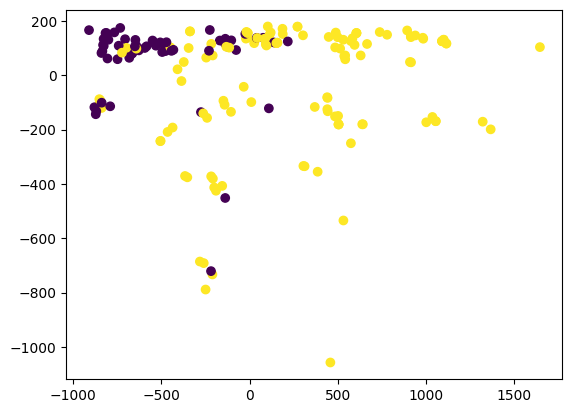

In [5]:
def display_KPCA_3D(data):
    data = np.transpose(data)
    print(len(data))

    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(data[0],data[1],data[2], c=y)

    plt.show()
    return

def display_KPCA_2D(data):
    data = np.transpose(data)
    print(len(data))

    fig = plt.figure()

    ax = fig.add_subplot(111)

    ax.scatter(data[0],data[1], c=y)

    plt.show()
    return



def kernel_PCA(K, dim):
    vals, vecs = np.linalg.eig(K)
    #skipy give same but swapped 
    vecs = np.transpose(vecs)

    # sort these based on the eigenvalues
    vecs = np.flip(vecs[np.argsort(vals)],0)[:dim]
    #vals = np.flip(vals[np.argsort(vals)],0)[:dim]

    #print(vecs)
    """for i in range(dim):
        vecs[i] = (vecs[i] / np.sqrt(vals[i]))"""

    feature_space = []
    for i in range(len(K)):
        new_coord = []
        for coord in range(dim):
            new_coord.append(K[:,i]@vecs[coord])
            
        feature_space.append(new_coord)

    return np.real(feature_space)


result_KPCA = kernel_PCA(center_K(K_train), 2)
display_KPCA_2D(result_KPCA)
    

In [6]:
def pairwise_dist(K):    
    dist=np.empty((len(K),len(K)))
    for i in range(len(K)):
        for j in range(len(K)):
            
            dist[i][j] = np.sqrt((K[i][i] + K[j][j] -2*K[i][j]))

    return dist


pairwise_dist(K_train)

array([[ 0.        , 18.70828693, 18.92088793, ..., 18.89444363,
        20.49390153, 18.02775638],
       [18.70828693,  0.        , 15.3622915 , ..., 15.45962483,
        24.53568829, 17.23368794],
       [18.92088793, 15.3622915 ,  0.        , ..., 15.26433752,
        24.69817807, 16.94107435],
       ...,
       [18.89444363, 15.45962483, 15.26433752, ...,  0.        ,
        25.        , 16.30950643],
       [20.49390153, 24.53568829, 24.69817807, ..., 25.        ,
         0.        , 23.08679276],
       [18.02775638, 17.23368794, 16.94107435, ..., 16.30950643,
        23.08679276,  0.        ]])

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


2


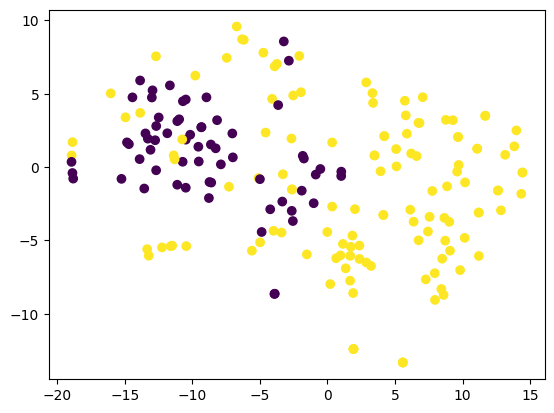

In [7]:
from sklearn.preprocessing import normalize
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

def tsne():

    model = TSNE(n_components=2, random_state=0, metric='precomputed')
    coords = model.fit_transform(pairwise_dist(K_train))
    #print(coords)
    display_KPCA_2D(coords)
tsne()

In [8]:
from collections import Counter

def constant_model_accuracy():
    test_list = Counter(y)

    res = test_list.most_common(1)
    return res[0][1] / len(y)

constant_model_accuracy()

In [9]:
print (len(K_train))

print (dataset.target[:150])

188
[ 1 -1 -1  1 -1  1 -1  1 -1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1  1
 -1  1  1 -1 -1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1
  1  1 -1  1  1 -1]


In [25]:




def SVM(seta , target  , C ,H):
    
    
    clf = SVC(C=C,kernel="precomputed",random_state=42)
    wl_kernel_2 = WeisfeilerLehman(n_iter= H, normalize=True, base_graph_kernel=VertexHistogram)
    G_train, G_test, y_train, y_test =  train_test_split(seta, target, test_size=0.2, random_state=42)
    Trained = wl_kernel_2.fit_transform(G_train)
    G_test_transformed = wl_kernel_2.transform(G_test)
    clf.fit(Trained,y_train)
    predicted = clf.predict(G_test_transformed)
    #print(G_test_transformed)
    #diff = predicted+y_test
    print(len(G_test_transformed))
    #value=0
    #for i in range( len(predicted)):
    #    if (diff[i]!=0):
    #        value=value+1
    #return (value/len(predicted))
    
    return accuracy_score(y_test, predicted)
print(SVM(G,y,10**2,10))




38
0.9210526315789473


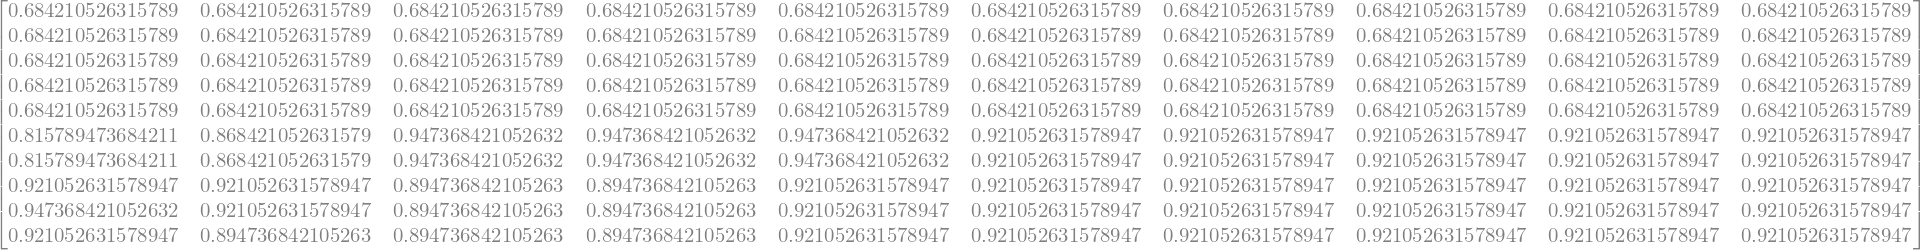

In [13]:
C= [10**-5 , 10**-4 , 10**-3 , 10**-2 , 10**-1 , 10 , 10**1 , 10**2 , 10**3 , 10**4]
H= [1,2,3,4,5,6,7,8,9,10]

def Select_hyperparameters(seta , target , C , H):
    matrix = np.zeros((len(C),len(H)))
    
    for i in range (len(C)):
        for j in range (len(H)):
            
            matrix[i][j] = SVM(seta,target,C[i],H[j])
    return matrix
matrix_result = Select_hyperparameters(G,y,C,H)
display(Matrix(matrix_result))

In [14]:
print(SVM(G,y,100,10))
print(SVM(G,y,100,10))


0.9210526315789473
0.9210526315789473


In [ ]:
print(matrix_result.max())
index = np.where(matrix_result == matrix_result.max())

for i in range (len(index[0])):
    print("combination %d and %d give value %f which is maximum" %(C[index[0][i]],H[index[1][i]],matrix_result.max()) )
    

0.8421052631578947
combination 10 and 10 give value 0.842105 which is maximum
combination 10 and 20 give value 0.842105 which is maximum
combination 10 and 30 give value 0.842105 which is maximum
combination 10 and 40 give value 0.842105 which is maximum
combination 10 and 50 give value 0.842105 which is maximum
combination 10 and 60 give value 0.842105 which is maximum
combination 10 and 70 give value 0.842105 which is maximum
combination 10 and 80 give value 0.842105 which is maximum
combination 10 and 90 give value 0.842105 which is maximum
combination 10 and 100 give value 0.842105 which is maximum
combination 100 and 10 give value 0.842105 which is maximum
combination 100 and 20 give value 0.842105 which is maximum
combination 100 and 30 give value 0.842105 which is maximum
combination 100 and 40 give value 0.842105 which is maximum
combination 100 and 50 give value 0.842105 which is maximum
combination 100 and 60 give value 0.842105 which is maximum
combination 100 and 70 give va